#This python file do the training with word2vec

In [1]:
import pandas as pd
import numpy as np
import pickle
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
from sklearn.datasets import fetch_20newsgroups
from nltk import download 
from nltk.corpus import stopwords
from nltk import word_tokenize

Using TensorFlow backend.


In [2]:
Data = fetch_20newsgroups(shuffle=True, remove=('headers', 'footers', 'quotes'))
data = pd.DataFrame({'filename':Data.filenames , 'category' : Data.target , 'news' : Data.data}) 

In [5]:
download('punkt') #tokenizer, run once
download('stopwords') #stopwords dictionary, run once
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] #restricts string to alphabetic characters only
    return doc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
corpus = [preprocess(text) for text in data['news']]

In [0]:
train_size = int(len(data) * .8)
 
train_posts = data['news'][:train_size]
train_tags = data['category'][:train_size]
train_files_names = data['filename'][:train_size]
test_posts = data['news'][train_size:]
test_tags = data['category'][train_size:]
test_files_names = data['filename'][train_size:]

In [0]:
model_vec = Word2Vec(corpus,min_count =10,size=100,workers=2,window=5,iter=30,sg=0)


In [0]:
vocab_size = len(model_vec.wv.vocab)
num_labels = 20
batch_size = 32


In [0]:
# 20 news groups
num_labels = 20
vocab_size = len(model_vec.wv.vocab)
batch_size = 32
 
# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)
 
x_train = tokenizer.texts_to_matrix(train_posts, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_posts, mode='tfidf')

In [25]:
x_train.shape

(9051, 11270)

In [0]:
encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [27]:
y_train[0]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
model = Sequential()
model.add(Dense(512, input_shape=(11270,)))
model.add(Activation('tanh'))
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(Activation('tanh'))
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(Activation('tanh'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()
 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=30,
                    verbose=1,
                    validation_split=(1.0/8))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               5770752   
_________________________________________________________________
activation_16 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_17 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)              

Text(0, 0.5, 'Accuracy')

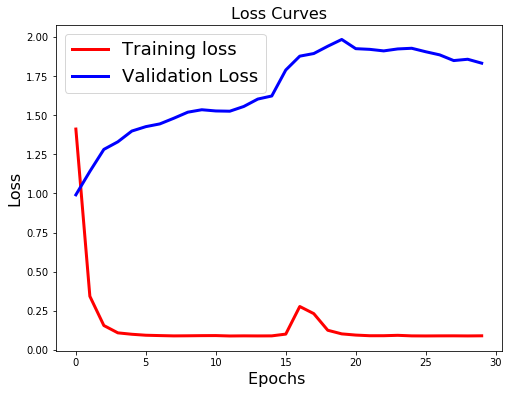

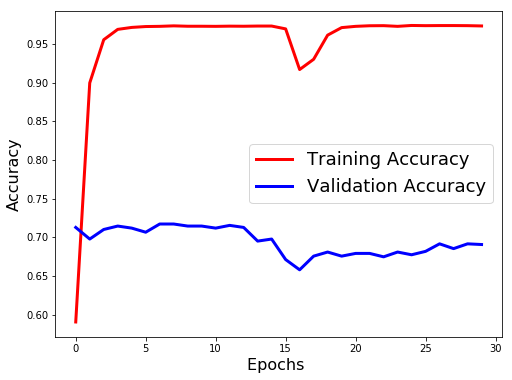

In [29]:
import matplotlib.pyplot as plt
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)

In [30]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
 
print('Test accuracy:', score[1])

2263/2263 [==============================] - 0s 193us/step
Test accuracy: 0.6791869199649981
